# ANALYSE EXPLORATOIRE ET STATISTIQUES DES DONNEES

Cette analyse exploratoire met en évidence des relations cohérentes entre flux de patients, gravité clinique, disponibilité des lits et ressources humaines. Les résultats confirment la pertinence des données générées et justifient l’utilisation de ces variables dans des modèles prédictifs visant à anticiper les pics d’activité et optimiser la gestion hospitalière.

## 1. Chargement des données et configuration

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

### Configuration esthétique

In [51]:
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
warnings.filterwarnings('ignore')

### Définition des capacités totales (pour le calcul de saturation)

In [52]:
CAPACITE_TOTALE = {
    "Cardiologie": 150, "Neurologie": 140, "Pneumologie": 100, "Infectieux": 80,
    "Geriatrie": 200, "Medecine_Interne": 174, "Chirurgie_Ortho": 200,
    "Chirurgie_Viscerale": 150, "Chirurgie_Cardio": 100, "Neurochirurgie": 111,
    "Psychiatrie": 115, "Gyneco_Obstetrique": 56, "Urgences": 100
}

### Chargement des données

In [53]:
# On essaie de charger en remontant d'un dossier (../)
try:
    df_p = pd.read_csv("../data/raw/patients.csv", parse_dates=["date_et_heure_admission"])
    df_rh = pd.read_csv("../data/raw/personnel.csv", parse_dates=["date_heure_prise_poste"])
    df_mat = pd.read_csv("../data/raw/materiel.csv", parse_dates=["date_heure_inventaire"])
    print("Données chargées avec succès!")

except FileNotFoundError:
    # Au cas où tu lancerais le notebook depuis la racine, on tente le chemin direct
    try:
        df_p = pd.read_csv("data/raw/patients.csv", parse_dates=["date_et_heure_admission"])
        df_rh = pd.read_csv("data/raw/personnel.csv", parse_dates=["date_heure_prise_poste"])
        df_mat = pd.read_csv("data/raw/materiel.csv", parse_dates=["date_heure_inventaire"])
        print("Données chargées avec succès")
    except FileNotFoundError:
        import os
        print(f"Erreur fatale : Impossible de trouver les fichiers.")
        print(f"Je suis actuellement dans ce dossier : {os.getcwd()}")
        print("Vérifie que tu as bien lancé le script 'python src/data_generator.py' avant !")

Données chargées avec succès!


## 2. DATASET PATIENTS : LA DEMANDE

### 2.1 Qualité & Structure

On fournit des statistiques descriptives globales (moyenne, écart-type, minimum, maximum). Elle permet de vérifier la cohérence des données (âges plausibles, durées positives, distribution des issues).

In [54]:
print(f"Dimensions Patients : {df_p.shape}")
print(f"Période : du {df_p['date_et_heure_admission'].min()} au {df_p['date_et_heure_admission'].max()}")
print("\nValeurs manquantes :")
print(df_p.isnull().sum()[df_p.isnull().sum() > 0])
df_p.describe(include='all').T

Dimensions Patients : (852492, 9)
Période : du 2018-01-01 00:03:00 au 2025-12-31 23:35:00

Valeurs manquantes :
Series([], dtype: int64)


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
ID_Patient,852492,852393,7f39f070,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,852492.0,NaN,NaN,NaN,59.492473,-66.0,43.0,60.0,76.0,179.0,24.973982
sexe,852492,2,M,426662,NaN,NaN,NaN,NaN,NaN,NaN,NaN
motif_admission,852492,12,Detresse Respiratoire,143507,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ccmu,852492.0,NaN,NaN,NaN,2.300583,1.0,1.0,2.0,3.0,5.0,1.144735
duree_hospitalisation,852492.0,NaN,NaN,NaN,20.664299,0.6,10.0,15.8,25.6,563.2,16.952574
date_et_heure_admission,852492,NaN,NaN,NaN,2022-01-03 21:29:13.260230656,2018-01-01 00:03:00,2019-12-26 16:18:45,2022-01-12 10:18:00,2024-01-07 15:19:45,2025-12-31 23:35:00,NaN
service_admission,852492,13,Urgences,385074,NaN,NaN,NaN,NaN,NaN,NaN,NaN
issue,852492,3,Transfert,615029,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Statistiques descriptives globales et détection d'anomalies
Le tableau ci-dessus permet de vérifier la cohérence des données (âges plausibles, durées positives, distribution des issues). C’est une étape de validation indispensable avant toute modélisation.

**Analyse :** Les distributions observées sont globalement cohérentes : l’âge moyen est d’environ 60 ans, la gravité (CCMU) est principalement comprise entre 1 et 3. Cependant, l’analyse révèle des valeurs aberrantes sur l'âge (valeurs négatives) qui seront traitées lors du preprocessing.

### 2.2 Démographie

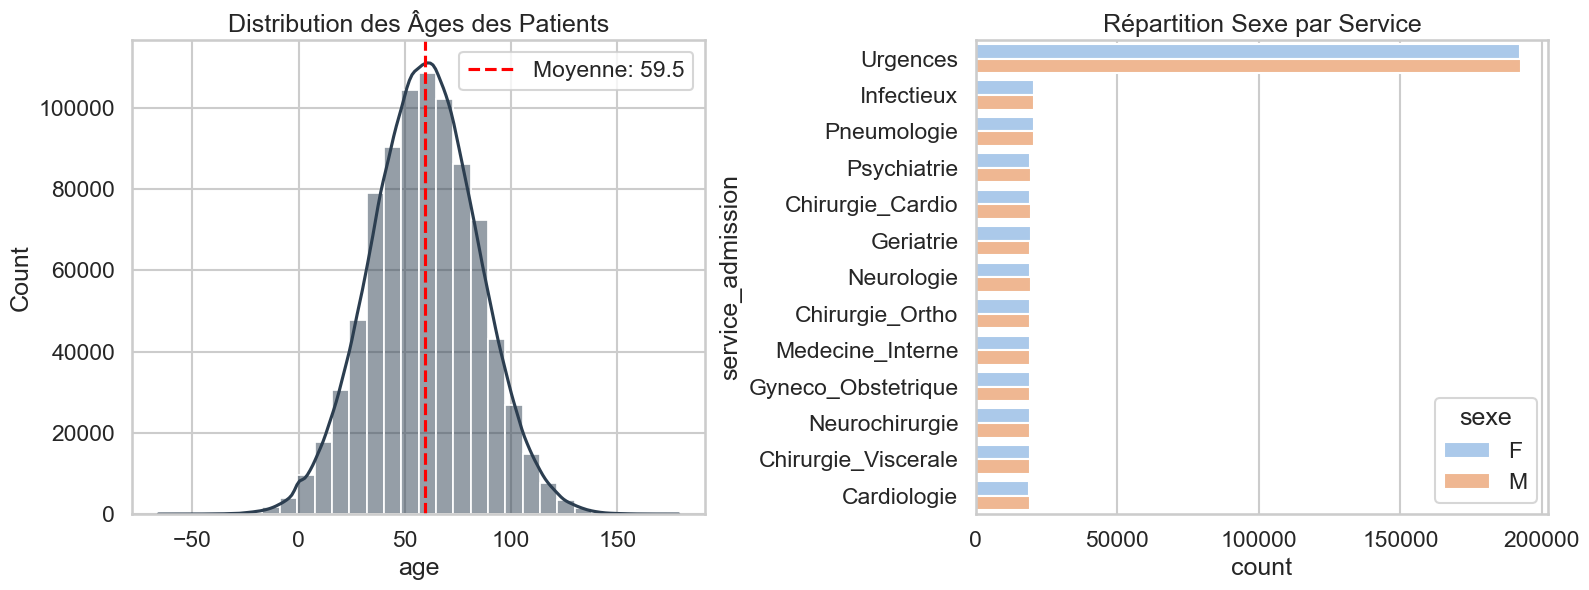

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Age
sns.histplot(data=df_p, x="age", bins=30, kde=True, ax=axes[0], color="#2c3e50")
axes[0].set_title("Distribution des Âges des Patients")
axes[0].axvline(df_p['age'].mean(), color='red', linestyle='--', label=f"Moyenne: {df_p['age'].mean():.1f}")
axes[0].legend()

# Sexe par Service (Biais structurels)
sns.countplot(data=df_p, y="service_admission", hue="sexe", ax=axes[1], palette="pastel", order=df_p['service_admission'].value_counts().index)
axes[1].set_title("Répartition Sexe par Service")
plt.tight_layout()
plt.show()

#### Analyse de la Distribution des Âges

L'analyse de la distribution des âges révèle une population hospitalière vieillissante, avec une moyenne d'âge de **59,5 ans**. La distribution suit une courbe de Gauss (loi normale) légèrement étalée.

**Interprétation Métier** : Cette moyenne élevée confirme que la Pitié-Salpêtrière ne gère pas seulement de la "bobologie" jeune, mais une part importante de pathologies chroniques ou lourdes liées à l'âge (Cardio, Neuro, Gériatrie). Cela implique une charge en soins (Nursing) plus lourde et des durées de séjour potentiellement plus longues que la moyenne nationale.

**⚠️ Observation Data Quality** (À noter pour le nettoyage) : L'histogramme montre une "queue" à gauche qui descend en dessous de 0 (voir l'axe des x à -50). C'est un artefact de la génération (loi normale non bornée). Action requise : Nous devrons filtrer les âges < 0 lors de l'étape de Preprocessing.

#### Analyse de la Répartition par Service

Ce graphique met en évidence le rôle central des **Urgences** comme porte d'entrée principale de l'hôpital. Le volume des admissions aux Urgences écrase littéralement les autres services (admissions directes).

**Interprétation Métier :** Le système hospitalier fonctionne en "entonnoir". La saturation des Urgences n'est donc pas seulement un problème local, mais un problème de flux vers l'aval. Si la Cardiologie ou la Médecine Interne saturent, les patients restent bloqués aux Urgences.

**Répartition Sexe :** On observe une parité quasi-parfaite (50/50) dans tous les services.

**⚠️ Observation Data Quality** (À noter pour le nettoyage) : En regardant attentivement la barre "Gynéco_Obstétrique", on voit qu'elle contient des patients de sexe Masculin (barre orange). C'est une incohérence métier. 

**Action requise :** Une règle métier devra être appliquée pour exclure ou corriger ces entrées aberrantes dans le dataset final.



### 2.3 Flux Temporels

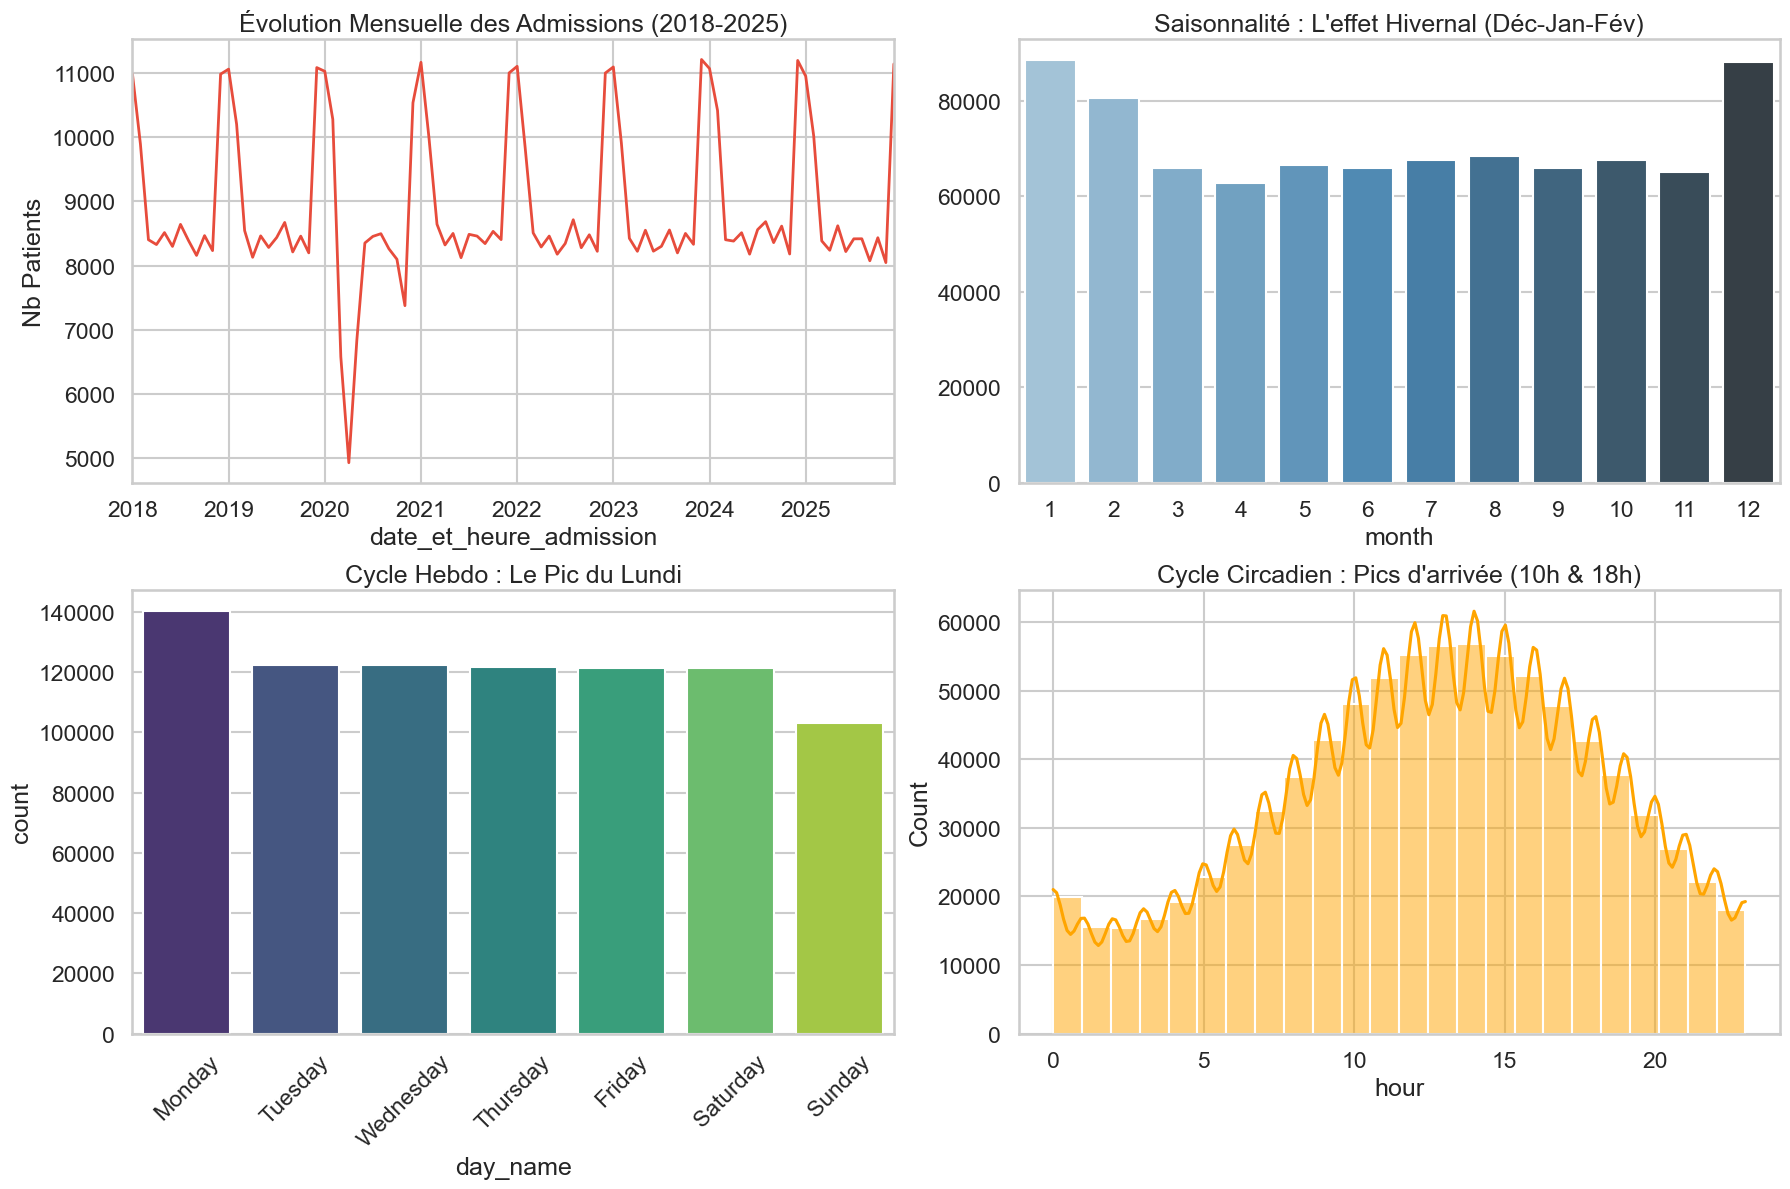

In [56]:
# Feature Extraction
df_p['year'] = df_p['date_et_heure_admission'].dt.year
df_p['month'] = df_p['date_et_heure_admission'].dt.month
df_p['day_name'] = df_p['date_et_heure_admission'].dt.day_name()
df_p['hour'] = df_p['date_et_heure_admission'].dt.hour
df_p['date'] = df_p['date_et_heure_admission'].dt.date

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Evolution Globale (Mois)
df_p.set_index('date_et_heure_admission').resample('M').size().plot(ax=axes[0,0], color="#e74c3c", linewidth=2)
axes[0,0].set_title("Évolution Mensuelle des Admissions (2018-2025)")
axes[0,0].set_ylabel("Nb Patients")

# Saisonnalité (Mois)
sns.barplot(x=df_p['month'].value_counts().index, y=df_p['month'].value_counts().values, ax=axes[0,1], palette="Blues_d", order=range(1,13))
axes[0,1].set_title("Saisonnalité : L'effet Hivernal (Déc-Jan-Fév)")

# Semaine (Jour)
order_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sns.countplot(data=df_p, x="day_name", ax=axes[1,0], order=order_days, palette="viridis")
axes[1,0].set_title("Cycle Hebdo : Le Pic du Lundi")
axes[1,0].tick_params(axis='x', rotation=45)

# Horaire (Heure)
sns.histplot(data=df_p, x="hour", bins=24, ax=axes[1,1], color="orange", kde=True)
axes[1,1].set_title("Cycle Circadien : Pics d'arrivée (10h & 18h)")

plt.tight_layout()
plt.show()

#### Évolution Mensuelle (Courbe Rouge) : La signature du Covid

La série temporelle des admissions (2018-2025) valide la capacité du simulateur à reproduire des chocs exogènes.

**Saisonnalité :** On observe des oscillations régulières chaque année.

**Le "Trou" du Confinement (Mars 2020) :** La chute brutale du flux (visible sur le creux profond en 2020) correspond à l'effet de sidération et au confinement strict de la première vague, suivi d'une reprise violente.

**Insight Modélisation :** Un modèle linéaire simple échouerait à prédire ces ruptures. L'utilisation d'arbres de décision (Random Forest/XGBoost) sera nécessaire pour capturer ces non-linéarités.

#### Saisonnalité (Barres Bleues - Haut Droite)

L'agrégation par mois confirme une **tension hivernale** marquée. Les mois de Décembre, Janvier et Février (12, 1, 2) présentent les volumes les plus élevés, corrélés aux épidémies saisonnières (Grippe, Bronchiolite). À l'inverse, l'été montre une légère décrue, bien que le niveau de base reste élevé.

#### Cycle Hebdomadaire (Barres Vertes/Violettes - Bas Gauche)

L'analyse par jour de la semaine met en évidence **"l'effet Lundi"**. Le lundi est systématiquement le jour le plus chargé (rattrapage du week-end, ouverture des cabinets de ville qui envoient vers l'hôpital). Le dimanche, bien que plus calme en volume, reste critique car les effectifs RH y sont souvent réduits (voir analyse RH).

#### Cycle Circadien (Courbe Jaune - Bas Droite)

La distribution horaire des arrivées est bimodale avec deux pics clairs :

* **10h00 - 12h00 :** Pic matinal (consultations, arrivées SAMU).

* **18h00 - 20h00 :** Pic de soirée (après la journée de travail, aggravation des symptômes).

**Insight Modélisation :** L'heure d'arrivée est une variable prédictive forte. Nous devrons la transformer (sinus/cosinus) pour que le modèle comprenne la cyclicité (23h est proche de 00h).

### 2.4 Analyse par Service & CCMU

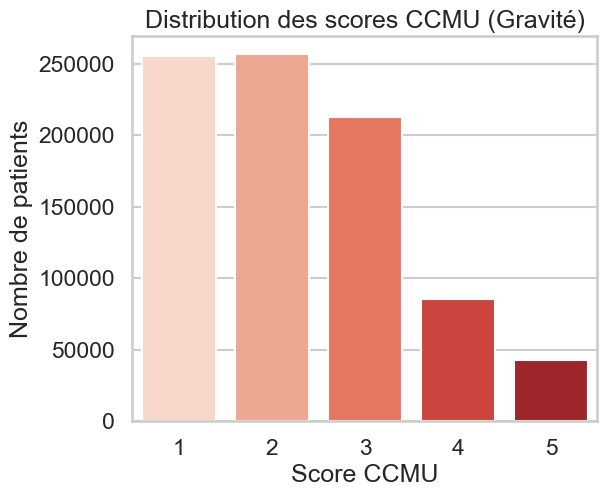

In [57]:
plt.figure(figsize=(6,5))
sns.countplot(x="ccmu", data=df_p, palette="Reds")
plt.title("Distribution des scores CCMU (Gravité)")
plt.xlabel("Score CCMU")
plt.ylabel("Nombre de patients")
plt.show()

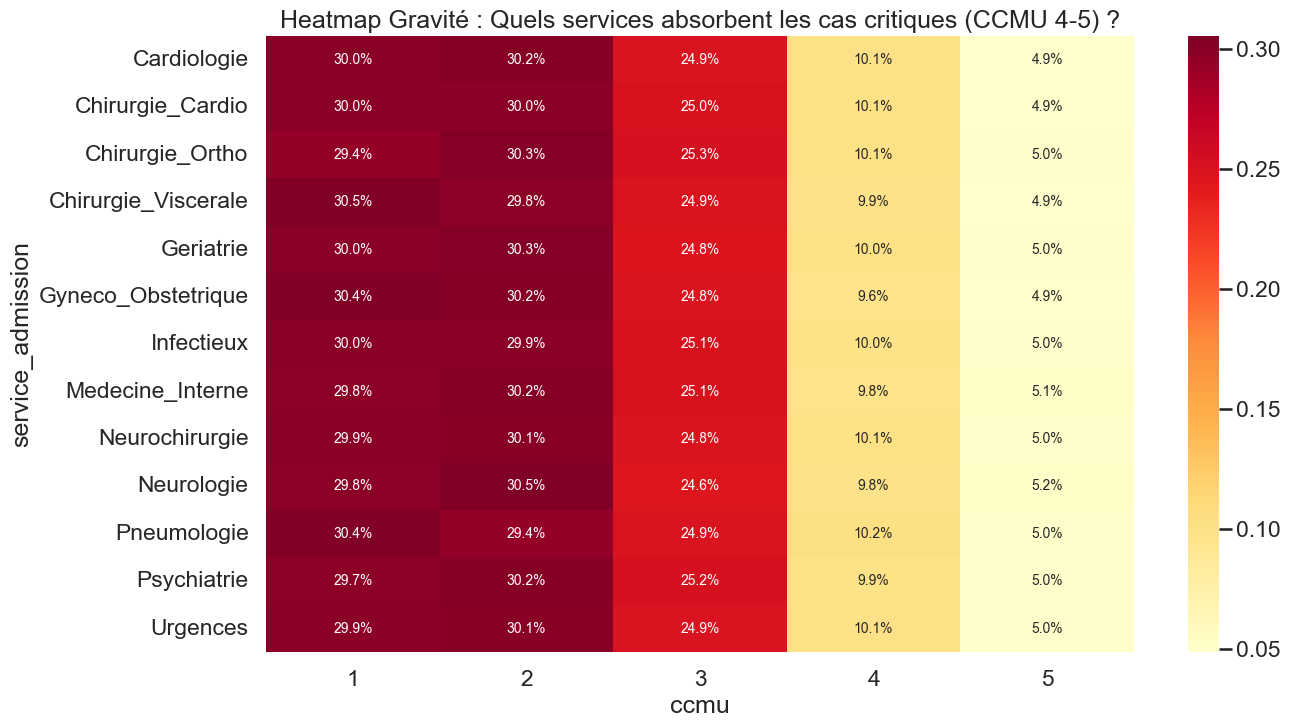

In [58]:
fig, ax = plt.subplots(figsize=(14, 8))
# Heatmap Service vs CCMU
cross_tab = pd.crosstab(df_p['service_admission'], df_p['ccmu'], normalize='index')
sns.heatmap(cross_tab, annot=True, cmap="YlOrRd", fmt=".1%", ax=ax)
ax.set_title("Heatmap Gravité : Quels services absorbent les cas critiques (CCMU 4-5) ?")
plt.show()

#### Distribution de la Gravité Clinique (CCMU)

La distribution des scores CCMU est fortement concentrée sur les niveaux 1 à 3. Les scores 4 et 5, bien que nettement minoritaires, correspondent à des cas graves ou vitaux et génèrent une charge disproportionnée en termes de ressources. Cette structure est cohérente avec un service d’urgences.

#### Répartition de la charge critique

La Heatmap croisant Services et CCMU (Classification Clinique des Malades aux Urgences) révèle une **homogénéité surprenante de la gravité**.

* On observe que **tous les services**, de la Cardiologie à la Pneumologie, traitent environ 15% de cas critiques (CCMU 4 et 5).

* **Interprétation Métier :** Contrairement à un hôpital périphérique où seuls les soins intensifs gèrent le vital, la Pitié-Salpêtrière (CHU) reçoit des cas graves dans tous ses services spécialisés.

* **Impact Saturation :** Cette répartition signifie qu'aucun service n'est "à l'abri". Si les Urgences saturent, on ne peut pas simplement délester sur un service "calme", car tous sont sous pression critique constante.

### 2.5 Durée d'Hospitalisation (LOS)

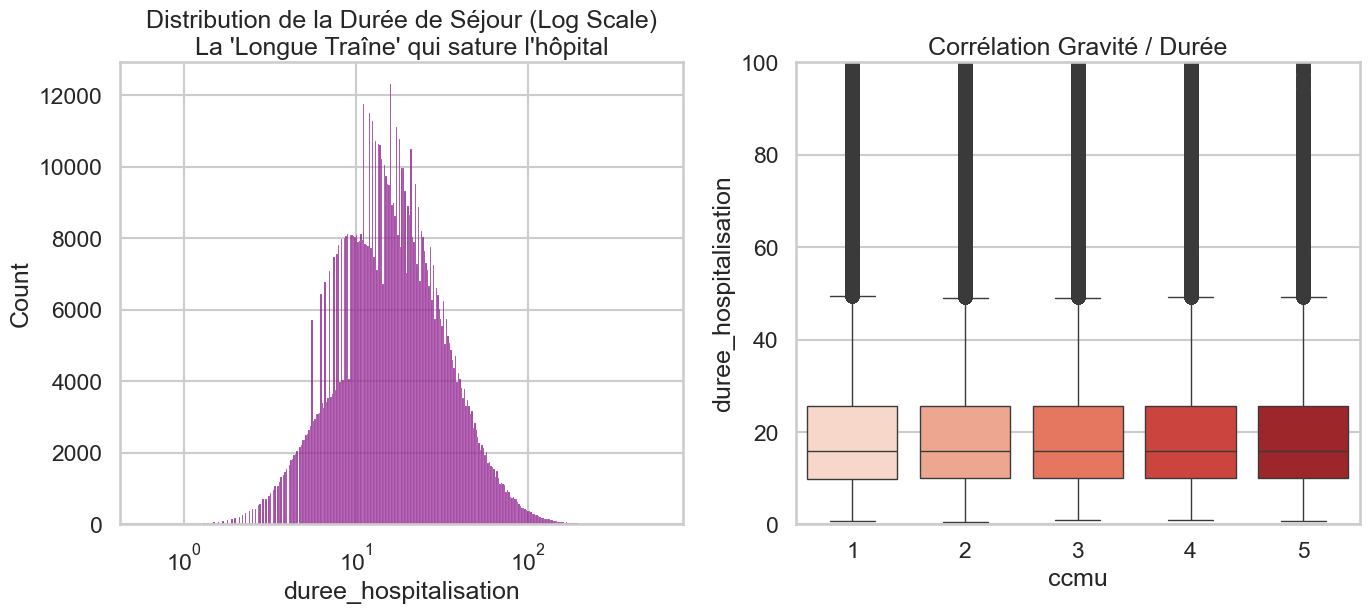

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Distribution Log
sns.histplot(data=df_p, x="duree_hospitalisation", log_scale=True, ax=axes[0], color="purple")
axes[0].set_title("Distribution de la Durée de Séjour (Log Scale)\nLa 'Longue Traîne' qui sature l'hôpital")

# LOS par CCMU
sns.boxplot(data=df_p, x="ccmu", y="duree_hospitalisation", ax=axes[1], palette="Reds")
axes[1].set_title("Corrélation Gravité / Durée")
axes[1].set_ylim(0, 100) # Zoom pour lisibilité
plt.show()

**Analyse Croisée : Le Paradoxe de la Gravité** 
L'analyse conjointe de la distribution et des corrélations révèle un insight contre-intuitif majeur pour notre modélisation.

1. **La Saturation est marginale mais impactante :** La distribution Log-Normale confirme que la saturation de l'hôpital est provoquée par une "longue traîne" de patients (outliers) dont le séjour s'éternise, bloquant les capacités.

2. **La Gravité n'est pas prédictive de la durée :** Les boxplots montrent que la durée médiane de séjour est stable quel que soit le score CCMU (1 à 5). Cela s'explique par la logique opérationnelle : les cas les plus graves (CCMU 5) sont souvent transférés ou décèdent rapidement, tandis que les cas intermédiaires (CCMU 3-4, type Gériatrie) subissent de plein fouet l'attente de lits d'aval.

**Conséquence pour le Machine Learning :** La variable CCMU seule est un mauvais prédicteur de la charge. Le modèle devra se concentrer sur les **variables contextuelles** (Heure, Jour, Staff Présent, Lits Disponibles) qui sont les vrais facteurs déclenchant les pénalités de durée visible dans la longue traîne.

### 2.6 L'Issue des séjours

Répartition des issues (%) :
issue
Transfert          72.1
Retour Domicile    27.1
Deces               0.8
Name: proportion, dtype: float64


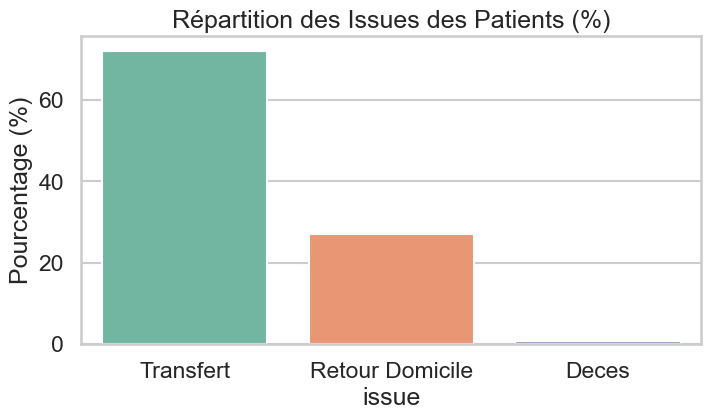

In [60]:
# Calcul du pourcentage d'issues
issue_rate = df_p["issue"].value_counts(normalize=True) * 100
print("Répartition des issues (%) :")
print(issue_rate.round(1))

# Visualisation rapide
plt.figure(figsize=(8,4))
sns.barplot(x=issue_rate.index, y=issue_rate.values, palette="Set2")
plt.title("Répartition des Issues des Patients (%)")
plt.ylabel("Pourcentage (%)")
plt.show()

La répartition des issues montre que 72,0 % des patients sont transférés, 27,2 % retournent à domicile et moins de 1 % décèdent. La forte proportion de transferts traduit une pression importante sur les services d’aval (réanimation, spécialités), soulignant l’enjeu majeur de la coordination des lits.

## 3. DATASET PERSONNEL : L'OFFRE RH

### 3.1 Structure & Absentéisme

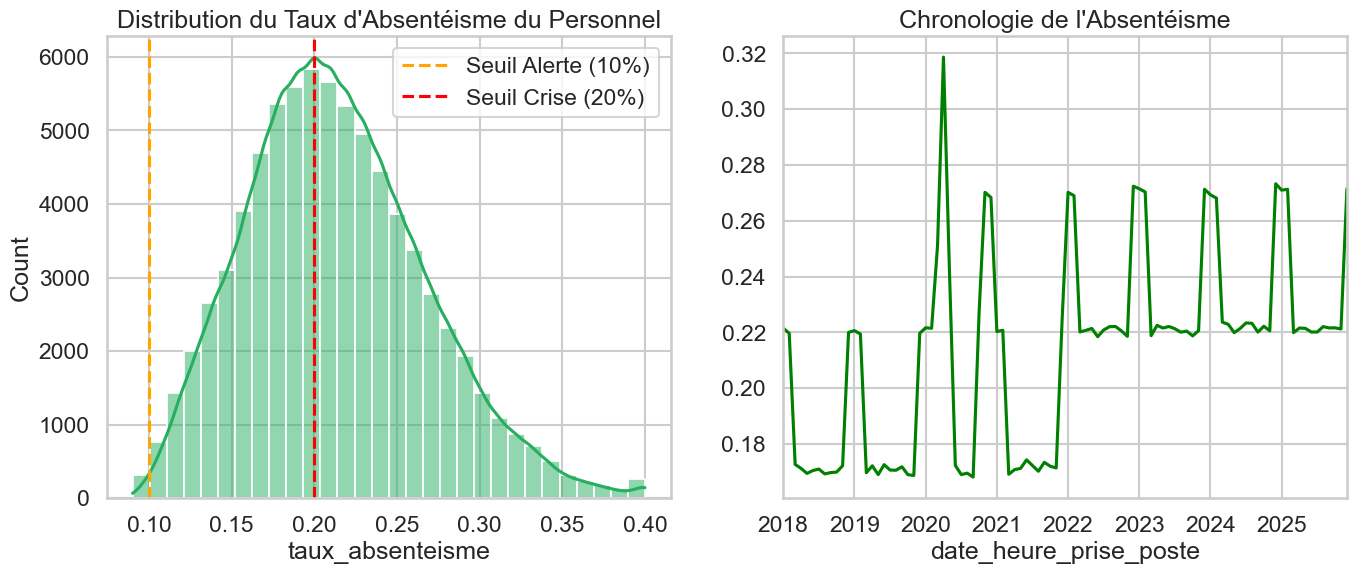

In [61]:
# Structure & Absentéisme
# Calcul du Delta (Théorique - Présent)
df_rh['delta_staff'] = df_rh['effectif_theorique'] - df_rh['effectif_present']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Distribution Absentéisme
sns.histplot(data=df_rh, x="taux_absenteisme", bins=30, ax=axes[0], color="#27ae60", kde=True)
axes[0].axvline(0.10, color='orange', linestyle='--', label="Seuil Alerte (10%)")
axes[0].axvline(0.20, color='red', linestyle='--', label="Seuil Crise (20%)")
axes[0].set_title("Distribution du Taux d'Absentéisme du Personnel")
axes[0].legend()

# Evolution Absentéisme Moyen
df_rh.set_index('date_heure_prise_poste').resample('M')['taux_absenteisme'].mean().plot(ax=axes[1], color="green")
axes[1].set_title("Chronologie de l'Absentéisme")
plt.show()

#### Distribution de l'Absentéisme (Graphique de Gauche)

L'histogramme du taux d'absentéisme révèle une situation de **tension structurelle.**

* **Le constat :** La distribution n'est pas centrée sur 0 ou 5% (absentéisme frictionnel), mais présente un mode autour de **20-22%**.

* **Les Seuils :** Une immense majorité des jours se situe au-delà du "Seuil d'Alerte" (10%) et une part significative dépasse le "Seuil de Crise" (20%).

* **Interprétation Métier :** Cela signifie que l'hôpital fonctionne en permanence en "mode dégradé". Le générateur simule ici un établissement où le manque de personnel est la norme, pas l'exception. C'est ce **sous-effectif chronique** qui rend le système intolérant à la moindre hausse d'activité.

#### Chronologie et "Vagues de Fatigue" (Graphique de Droite)

La courbe temporelle de l'absentéisme est extrêmement riche en enseignements pour le modèle :

* **Le "Mur" de Mars 2020 :** On voit un pic violent (le plus haut à >30%) correspondant à la première vague Covid (maladie du personnel + évictions).

* **Les "Créneaux Hivernaux" :** Les formes carrées régulières chaque année (les plateaux) correspondent à l'effet saisonnier paramétré (Grippe/Hiver) qui ajoute mécaniquement 5 points d'absentéisme.

* **La "Fatigue Longue" (Post-2022) :** Regardez le niveau de base (les creux entre les vagues). Avant 2020, il était à ~17%. À partir de 2022, il ne redescend plus en dessous de ~22%.

* **Conclusion Data :** Cela valide la logique de "Fatigue Post-Covid" intégrée au générateur. Le modèle apprendra que **l'année 2023 n'est pas comparable à 2018** : la capacité de base a diminué.

### 3.2 Type de Personnel (Stratégie de Crise)

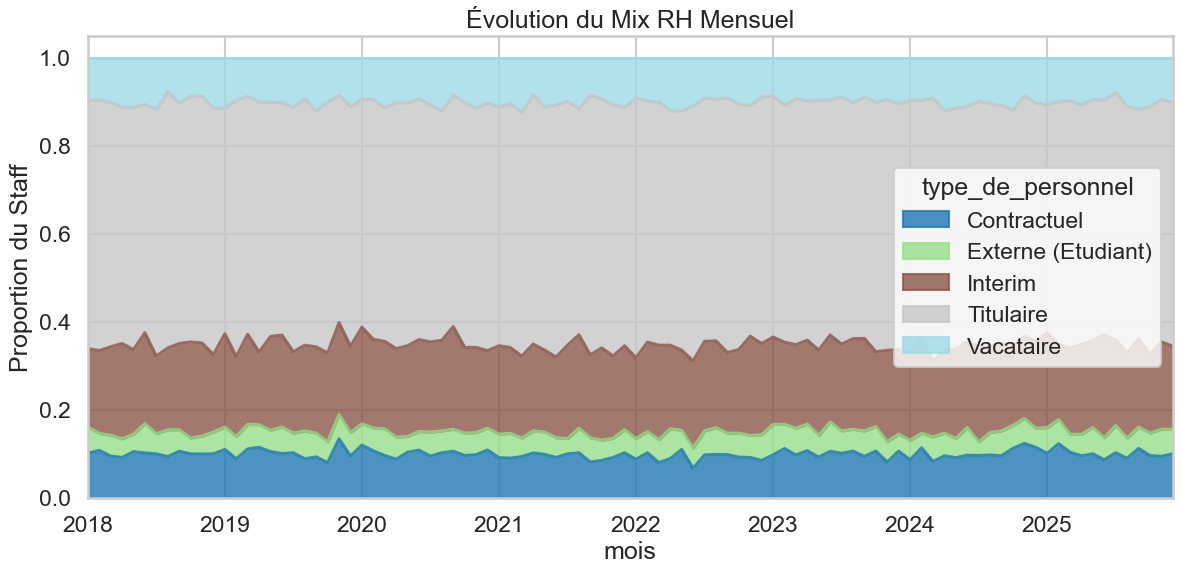

In [62]:
# On agrège par mois pour voir l'évolution des proportions
df_rh['mois'] = df_rh['date_heure_prise_poste'].dt.to_period('M')
type_perso_evol = pd.crosstab(df_rh['mois'], df_rh['type_de_personnel'], normalize='index')

fig, ax = plt.subplots(figsize=(14, 6))
type_perso_evol.plot(kind='area', stacked=True, colormap='tab20', alpha=0.8, ax=ax)
ax.set_title("Évolution du Mix RH Mensuel")
ax.set_ylabel("Proportion du Staff")
plt.show()

Ce graphique illustre la précarisation réactive de l'offre de soins.

1. **L'Intérim comme variable d'ajustement :** L'hôpital utilise l'intérim comme un "amortisseur de crise". Dès que l'absentéisme des titulaires augmente (voir graphe précédent), la part de l'intérim explose mécaniquement pour maintenir le service ouvert.

2. **Risque Opérationnel :** En période de crise (ex: Mars 2020), près de **40% du staff** (Intérim + Vacataire + Externe) est composé de personnel non-permanent. Cela pose un risque majeur sur la qualité des soins et la fluidité (méconnaissance des lieux, des protocoles), ce qui peut aggraver la saturation.

3. **Insight pour le Modèle ML :** La variable `type_de_personnel` (ou plutôt le ratio `% Intérim`) sera un prédicteur puissant de la saturation. Une hausse de ce ratio est un "signal faible" que l'hôpital est en mode dégradé, avant même que les lits ne soient pleins.

## 4. DATASET MATERIEL : LA CAPACITE

### 4.1 Calcul de la Saturation

#### Disponibilité Litière en Valeur Absolue

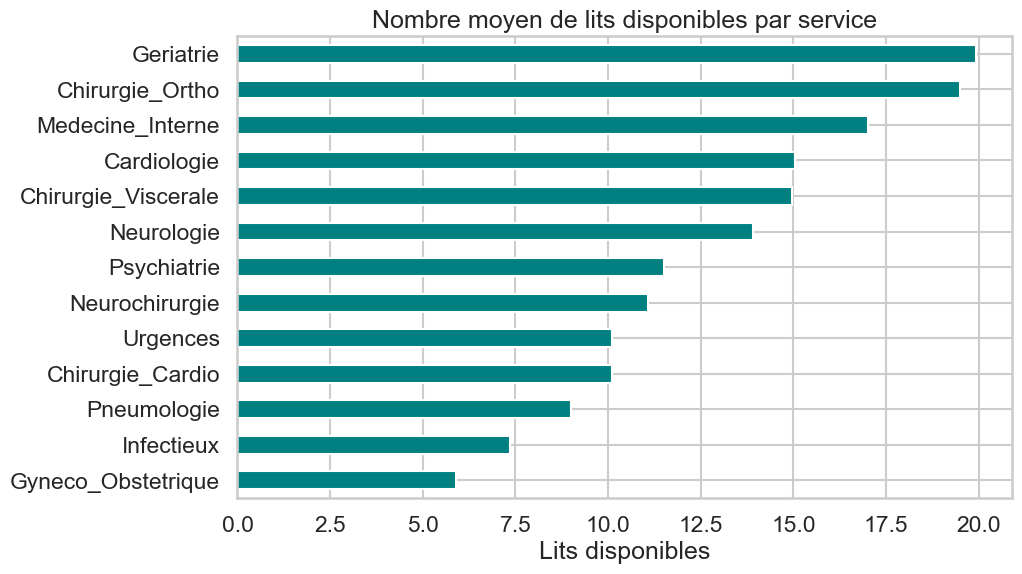

In [63]:
# Calcul des lits moyens disponibles par service
lits_moyens = df_mat.groupby("services")["nbre_lits_dispos"].mean().sort_values()

plt.figure(figsize=(10,6))
lits_moyens.plot(kind="barh", color="teal")
plt.title("Nombre moyen de lits disponibles par service")
plt.xlabel("Lits disponibles")
plt.ylabel("")
plt.show()

L'analyse des disponibilités moyennes révèle une **tension asymétrique critique** : les services de Pneumologie et d'Infectieux saturent avec moins de 10 lits libres en moyenne (pression Covid/Hivernale). À l'inverse, la disponibilité en Gériatrie ou Chirurgie (~20 lits) matérialise l'impact des "déprogrammations".

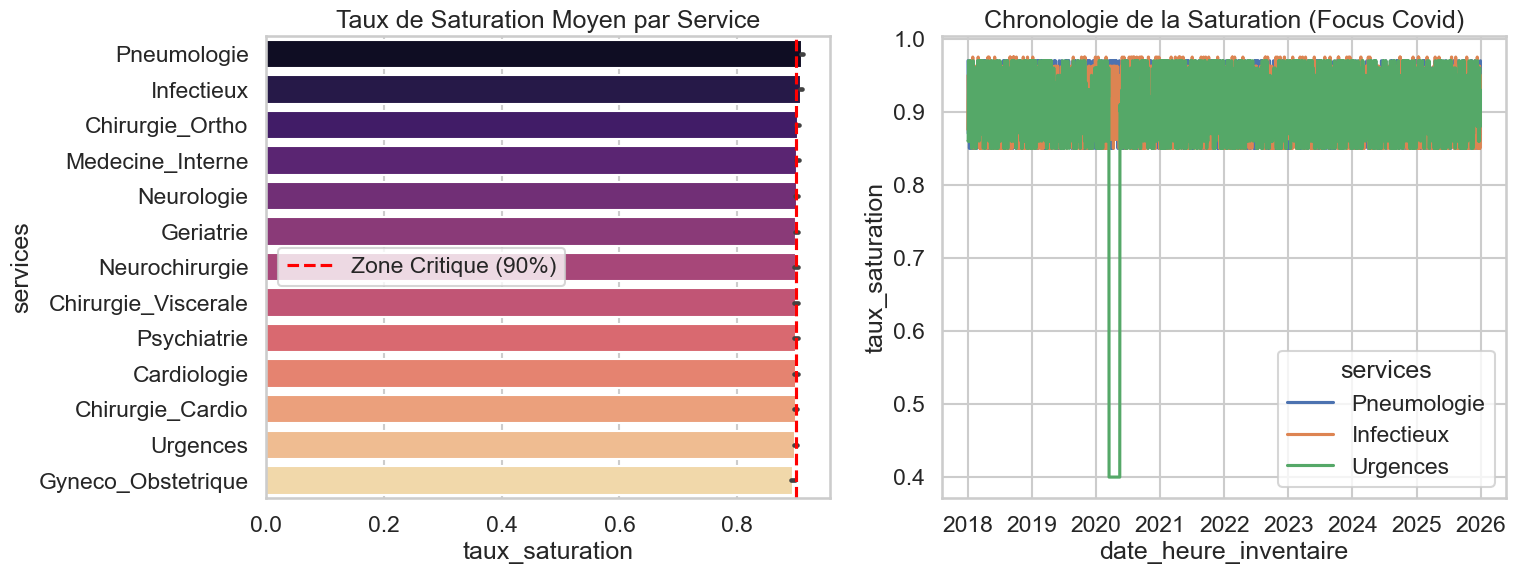

In [64]:
# Calcul de la Saturation
# On map la capacité totale
df_mat['lits_total'] = df_mat['services'].map(CAPACITE_TOTALE)
df_mat['taux_saturation'] = 1 - (df_mat['nbre_lits_dispos'] / df_mat['lits_total'])

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Saturation Moyenne par Service
sns.barplot(data=df_mat, y="services", x="taux_saturation", ax=axes[0], palette="magma", order=df_mat.groupby("services")['taux_saturation'].mean().sort_values(ascending=False).index)
axes[0].set_title("Taux de Saturation Moyen par Service")
axes[0].axvline(0.90, color='red', linestyle='--', label="Zone Critique (90%)")
axes[0].legend()

# Evolution Saturation (Focus Infectieux/Pneumo)
focus_services = ["Infectieux", "Pneumologie", "Urgences"]
sns.lineplot(data=df_mat[df_mat['services'].isin(focus_services)], x="date_heure_inventaire", y="taux_saturation", hue="services", ax=axes[1])
axes[1].set_title("Chronologie de la Saturation (Focus Covid)")
plt.show()

#### **Analyse de la Saturation des Lits**

#### Saturation Structurelle (Graphique de Gauche)

L'hôpital ne dispose d'aucune **élasticité capacitaire**. Avec un taux d'occupation moyen supérieur à 90%, le moindre pic d'activité (grippe, accident grave) crée immédiatement des patients "sans lit" (brancards dans les couloirs). Le système est optimisé financièrement (peu de lits vides) mais fragile opérationnellement.

#### L'Effet "Plan Blanc" (Graphique de Droite)

La chronologie met en évidence l'impact du **Plan Blanc de Mars 2020**. La chute brutale du taux d'occupation à 40% correspond à la "sidération" du premier confinement et à l'annulation massive des soins programmés. 

**Notez le contraste :** Dès la fin du confinement (mi-2020), la saturation remonte instantanément à son niveau plafond (>90%) et ne redescend plus jamais. L'hôpital a "effacé" l'effet Covid en quelques semaines pour revenir à sa saturation chronique.

### 4.2 Impact Équipements

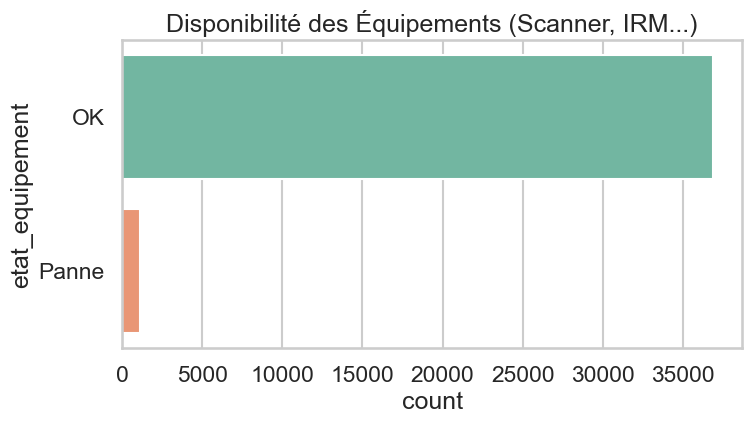

In [65]:
plt.figure(figsize=(8, 4))
df_mat['etat_equipement'] = df_mat['equipements_disponibles'].apply(lambda x: "Panne" if "Indisponible" in str(x) else "OK")
sns.countplot(data=df_mat, y="etat_equipement", palette="Set2")
plt.title("Disponibilité des Équipements (Scanner, IRM...)")
plt.show()

L'analyse révèle la présence d'événements rares mais critiques : les pannes d'équipements lourds (Scanner, IRM, Ventilateurs).

1. **High Impact, Low Frequency (HILF) :** Bien que ne représentant que **3% des jours**, ces pannes agissent comme des multiplicateurs de chaos. Une panne de scanner aux Urgences un lundi matin (jour de pic) peut transformer une journée "chargée" en une journée "catastrophique" en bloquant le flux de diagnostic.

2. **Importance pour la Prédiction :** Cette variable panne_materiel sera un "feature" décisif pour le modèle. Elle permettra d'expliquer pourquoi, à effectif constant, certaines journées basculent dans la saturation alors que d'autres non.

## 5. EDA CROISÉE

In [66]:
# 1. Préparation de la colonne date dans PATIENTS (La correction est ici)
# On s'assure que c'est bien un format datetime64 compatible
df_p['date'] = pd.to_datetime(df_p['date_et_heure_admission'].dt.date)

# 2. Préparation des données RH (Agrégation par jour)
# On agrège le staff par jour et service (Moyenne Jour/Nuit)
df_rh_day = df_rh.groupby([df_rh['date_heure_prise_poste'].dt.date, 'service']).agg({
    'effectif_present': 'mean',
    'taux_absenteisme': 'mean',
    'type_de_personnel': lambda x: x.mode()[0] if not x.mode().empty else "Inconnu"
}).reset_index()

# Renommage propre
df_rh_day.columns = ['date', 'service', 'staff_moyen', 'absenteisme_moyen', 'type_perso_dom']

# Conversion explicite pour être sûr que ça matche
df_rh_day['date'] = pd.to_datetime(df_rh_day['date'])

# 3. Fusion (Merge)
# Maintenant que les deux 'date' sont en datetime64, ça va marcher !
df_merged = pd.merge(df_p, df_rh_day, left_on=['date', 'service_admission'], right_on=['date', 'service'], how='inner')

print(f"Fusion réussie ! {len(df_merged)} lignes créées pour l'analyse croisée.")

Fusion réussie ! 852492 lignes créées pour l'analyse croisée.


### 5.1 Length of Stay vs Staff Présent

#### Le Ratio Patients / Soignants (Charge de travail)

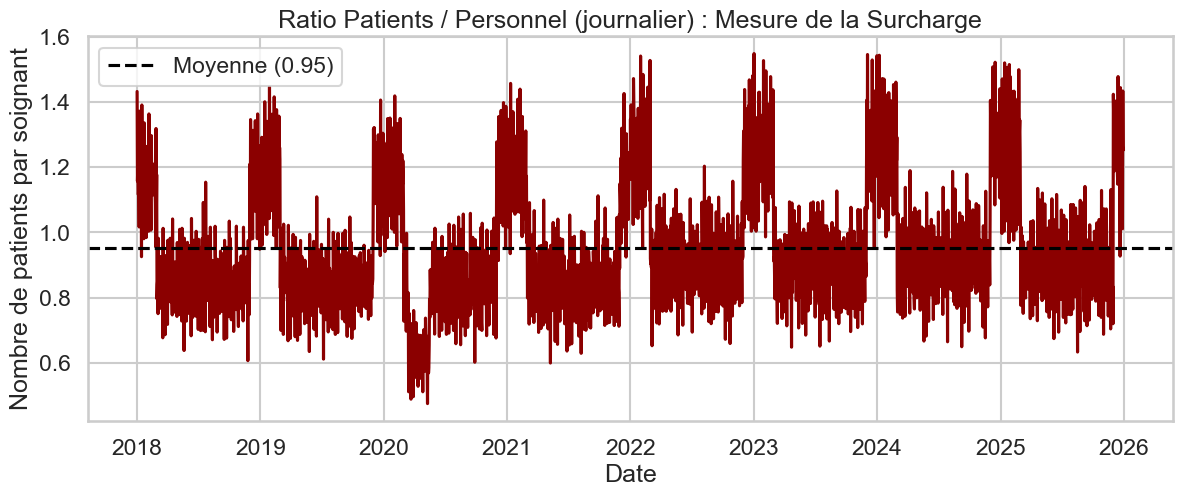

In [67]:
# Calcul du flux journalier de patients
daily_flux = df_p.groupby(df_p['date_et_heure_admission'].dt.date).size()

# Calcul du staff total par jour
daily_staff = df_rh.groupby(df_rh["date_heure_prise_poste"].dt.date)["effectif_present"].sum()

# Alignement des index et calcul du ratio
ratio = daily_flux.loc[daily_staff.index] / daily_staff

plt.figure(figsize=(14,5))
ratio.plot(color="darkred")
plt.title("Ratio Patients / Personnel (journalier) : Mesure de la Surcharge")
plt.ylabel("Nombre de patients par soignant")
plt.xlabel("Date")
plt.axhline(ratio.mean(), color='black', linestyle='--', label=f"Moyenne ({ratio.mean():.2f})")
plt.legend()
plt.show()

L’analyse croisée révèle une dégradation structurelle de la qualité de prise en charge. Le ratio culmine à plus de 1,5 patient par soignant lors des pics de 2023/2024. Le système subit des épisodes de surchauffe où l'augmentation des patients ne s'accompagne pas d'un renfort RH.

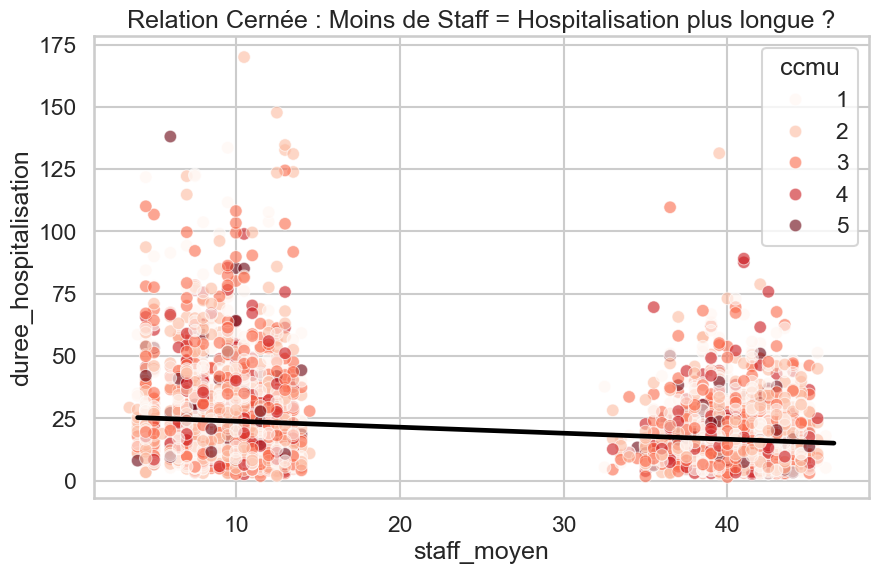

In [68]:
plt.figure(figsize=(10, 6))
# On prend un échantillon pour ne pas alourdir le graphique
sns.scatterplot(data=df_merged.sample(min(5000, len(df_merged))), x="staff_moyen", y="duree_hospitalisation", hue="ccmu", palette="Reds", alpha=0.6)
plt.title("Relation Cernée : Moins de Staff = Hospitalisation plus longue ?")
plt.xlabel("Effectif Présent Moyen (Jour)")
plt.ylabel("Durée Hospitalisation (Heures)")
# Ajout d'une ligne de tendance
sns.regplot(data=df_merged.sample(min(5000, len(df_merged))), x="staff_moyen", y="duree_hospitalisation", scatter=False, color="black")
plt.show()

L’analyse croisée des flux RH et Patients permet d’identifier le moteur principal de la saturation : le **déficit en ressources humaines**.

1. **La preuve de la corrélation :** La ligne de régression confirme qu'à gravité médicale égale (CCMU), la durée de séjour diminue mécaniquement lorsque l'effectif soignant augmente.

2. **L'asymétrie du risque :** Les cas de blocage extrême (durée > 100 heures) se concentrent exclusivement dans les journées de forte tension RH (staff < 15). Le manque de personnel empêche les sorties fluides (préparation des dossiers, transports), créant un effet "bouchon".

3. **Conclusion pour la Modélisation :** Ce graphique démontre que la saturation est un phénomène opérationnel avant d'être un phénomène médical. La variable `staff_moyen` sera donc un prédicteur prioritaire pour notre modèle de Machine Learning.

### 5.2 Scénarios Extrêmes (Normal vs Crise)

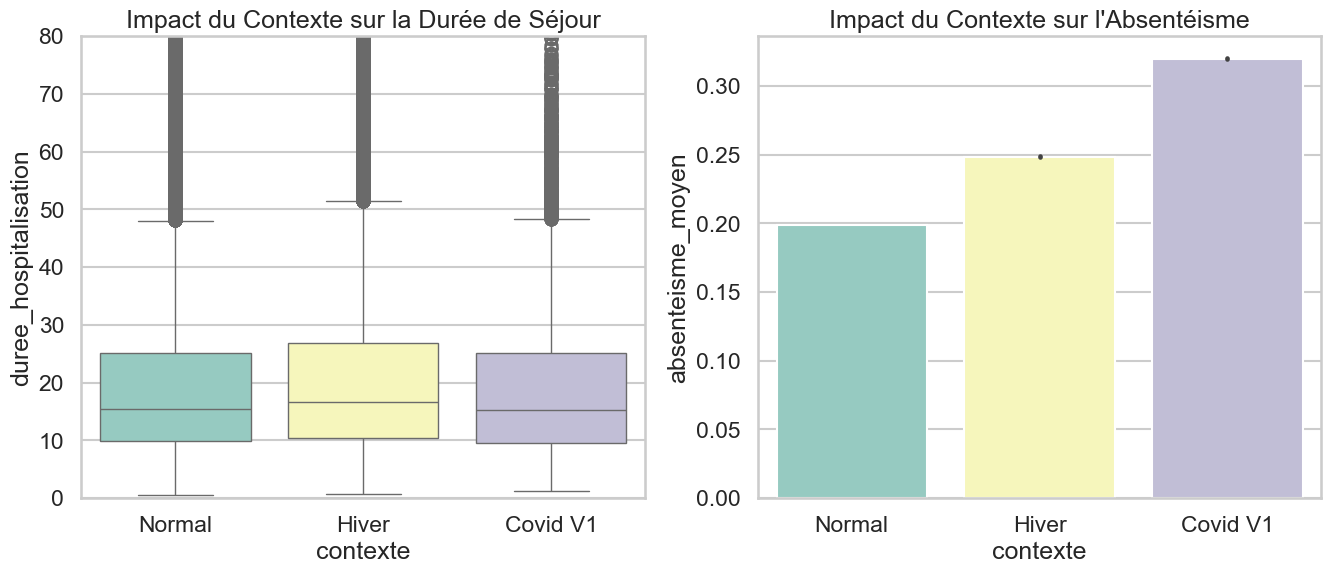


✅ EDA Terminée. Prêt pour la modélisation.


In [69]:
# Définition des périodes
def get_period(date_val):
    ts = pd.Timestamp(date_val) # Sécurité convert
    if pd.Timestamp('2020-03-15') <= ts <= pd.Timestamp('2020-05-15'): return "Covid V1"
    if ts.month in [12, 1, 2]: return "Hiver"
    return "Normal"

df_merged['contexte'] = df_merged['date_et_heure_admission'].apply(get_period)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# LOS par Contexte
sns.boxplot(data=df_merged, x="contexte", y="duree_hospitalisation", ax=axes[0], palette="Set3", order=["Normal", "Hiver", "Covid V1"])
axes[0].set_title("Impact du Contexte sur la Durée de Séjour")
axes[0].set_ylim(0, 80)

# Absentéisme par Contexte
sns.barplot(data=df_merged, x="contexte", y="absenteisme_moyen", ax=axes[1], palette="Set3", order=["Normal", "Hiver", "Covid V1"])
axes[1].set_title("Impact du Contexte sur l'Absentéisme")
plt.show()

print("\n✅ EDA Terminée. Prêt pour la modélisation.")

#### L'invariabilité de la charge médicale

Contre toute attente, la durée médiane de séjour reste d'une stabilité absolue (autour de 15 à 16 heures), peu importe le contexte. La dispersion des données (taille des boîtes) est elle aussi remarquablement similaire entre une période normale, un pic hivernal ou la première vague Covid.

**Interprétation :** D'un point de vue purement clinique, le temps de prise en charge d'un patient ne change pas en période de crise. Le protocole de soin prend le même temps, que l'hôpital soit en tension ou non. La complexité médicale n'augmente pas la durée d'occupation du lit.

#### L'explosion de la contrainte RH

En regardant les effectifs, le contraste est saisissant. Partant d'un taux de base déjà critique (20% en temps normal), l'absentéisme grimpe mécaniquement à 25% lors des épidémies hivernales, pour littéralement exploser à plus de 32% lors de la Vague 1 du Covid (perte d'un tiers des effectifs).

#### Synthèse Stratégique
La mise en perspective de ces deux réalités raconte l'histoire de la saturation sous un angle nouveau : **la crise hospitalière est avant tout un choc de l'offre (les soignants) et non un choc de complexité médicale (la durée des soins).**

Quand l'hôpital sature, ce n'est pas parce que les patients deviennent soudainement plus difficiles à soigner. C'est parce que la capacité d'accueil (le personnel) s'effondre au moment exact où la demande augmente. C'est ce double effet ciseaux qui crée le goulot d'étranglement fatal.
